# U-Net for Image Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Project Overview

This project explores the implementation and application of the U-Net architecture, initially developed for image segmentation tasks. Our objective is to first apply U-Net to segment images effectively in various datasets, such as medical and satellite imagery. Subsequently, we adapt the U-Net architecture for image classification by modifying its network structure. The goal is to demonstrate the versatility of U-Net in handling different types of deep learning tasks in computer vision, assessing its performance in both segmentation and classification scenarios.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

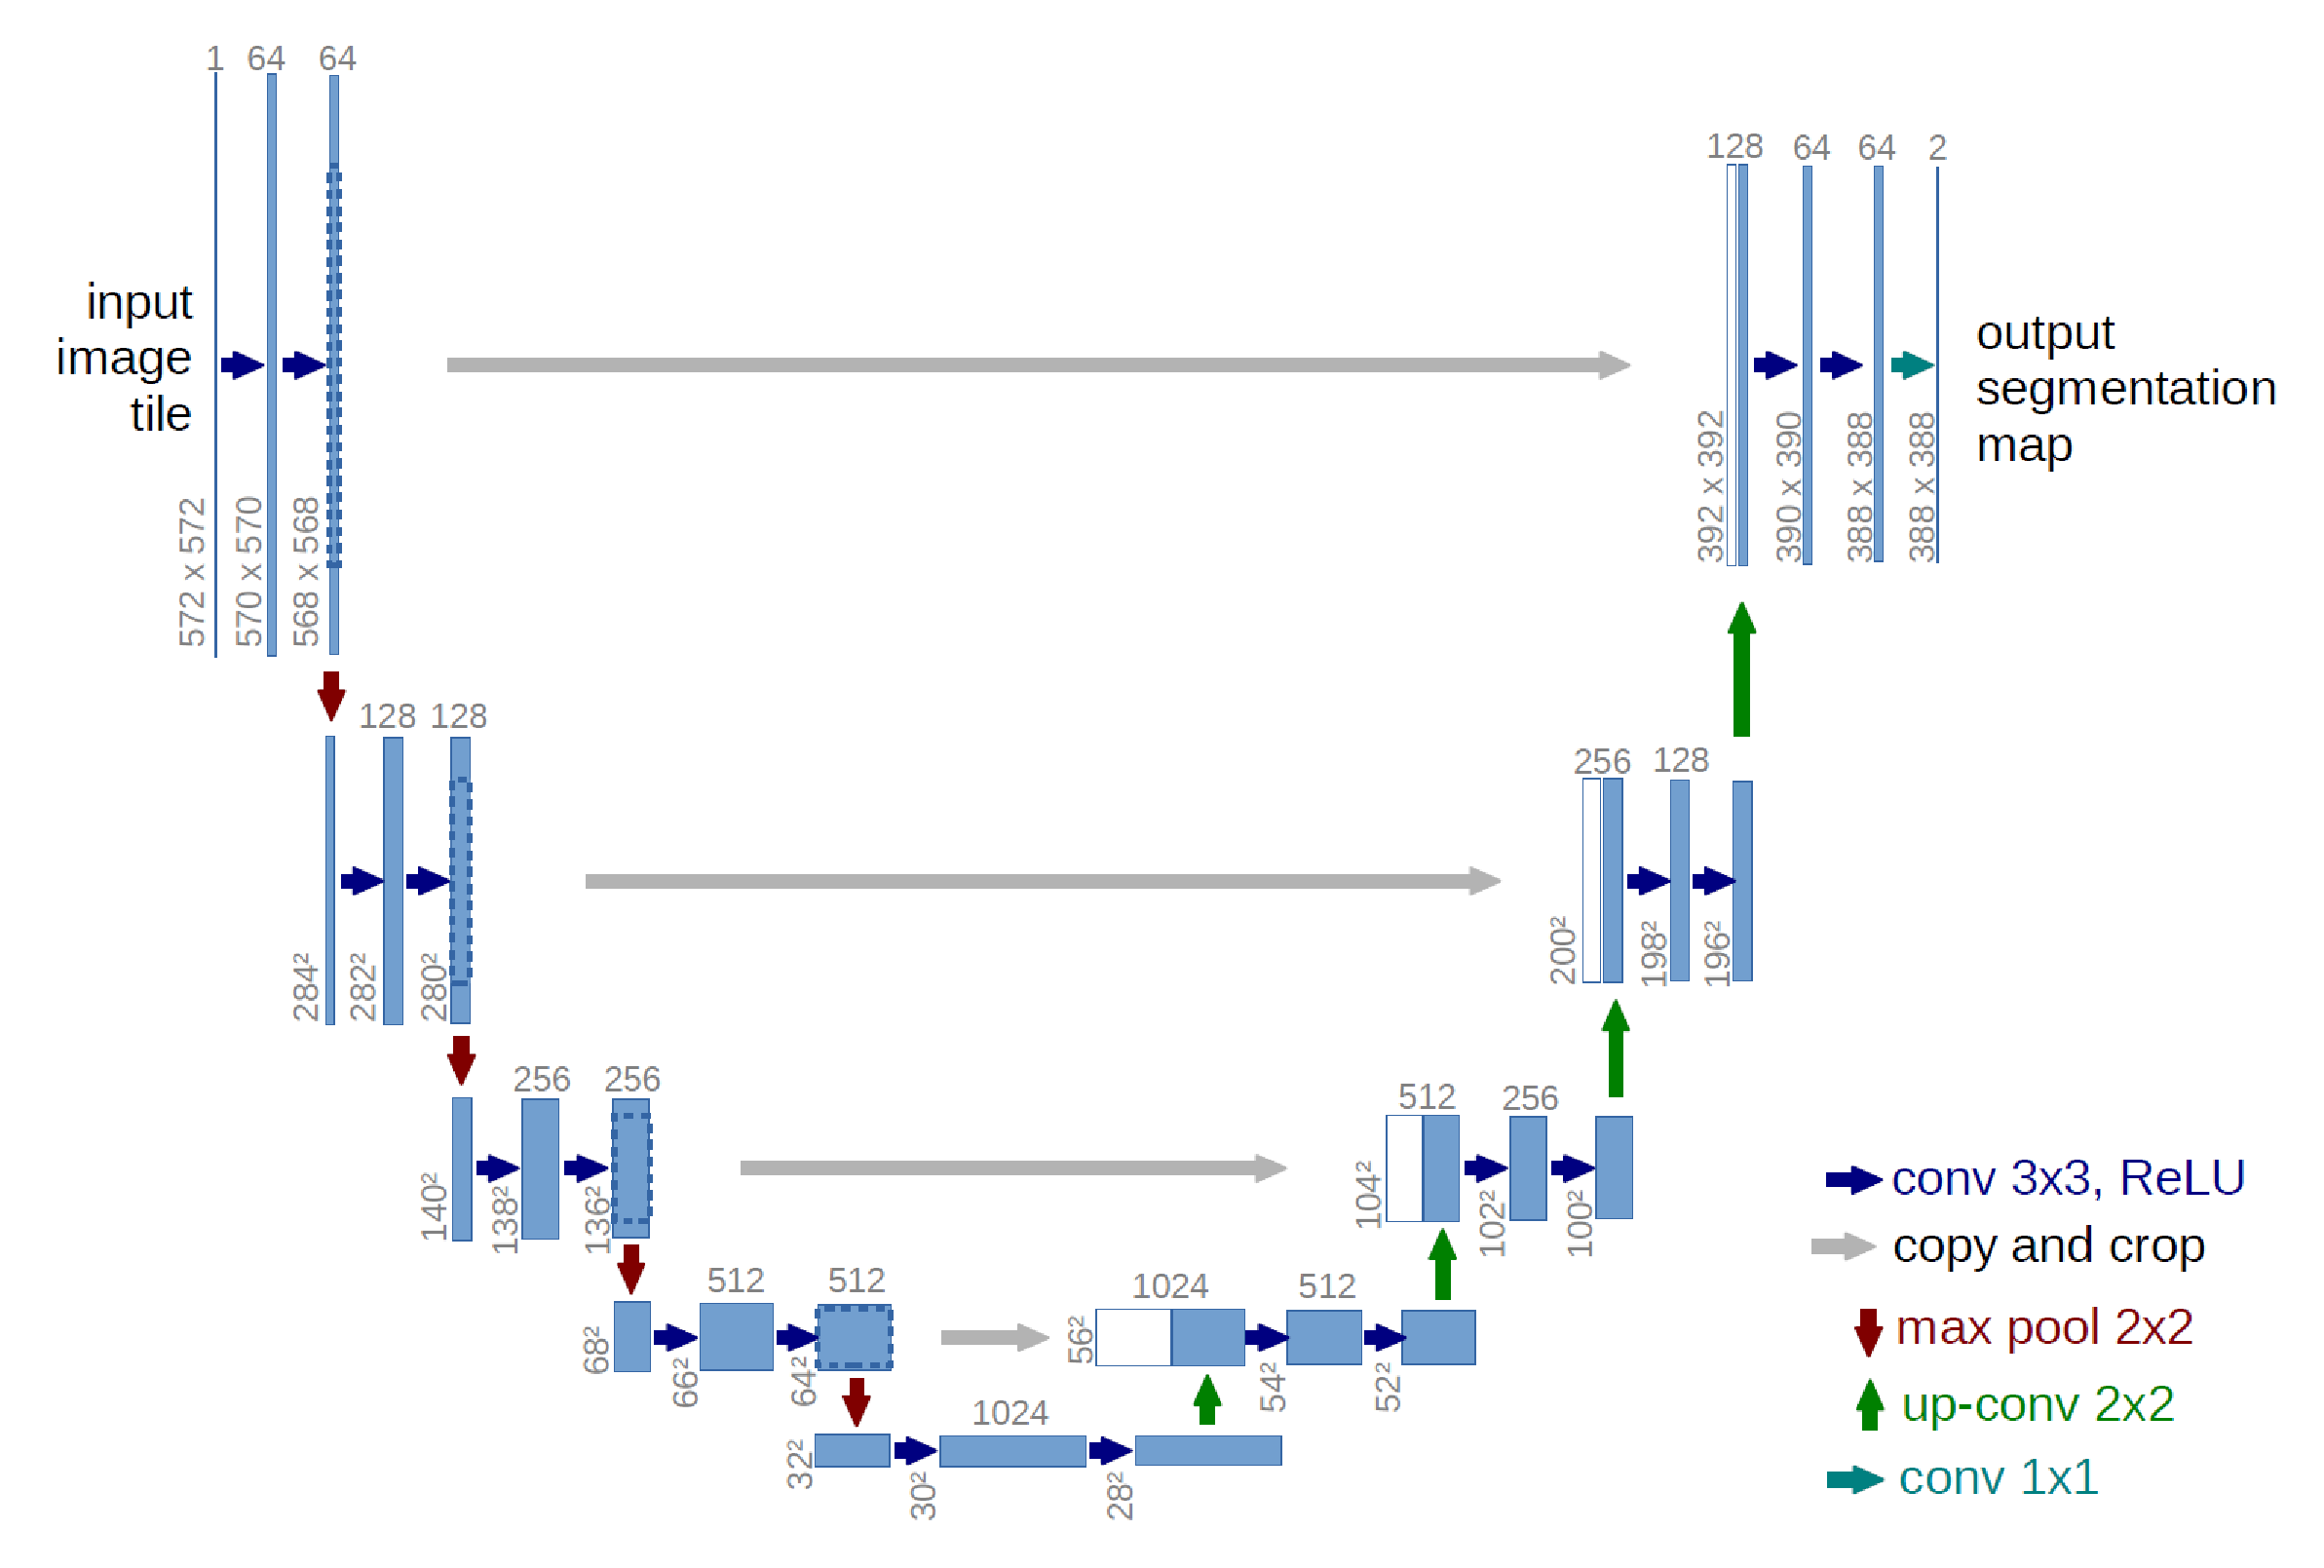

In [ ]:
# Specify the path to your image file
image_path = 'UNET_architecture.png'

# Load the image using matplotlib's imread function
img = mpimg.imread(image_path)

# Create a larger figure with higher DPI
plt.figure(figsize=(10, 8), dpi=300)

plt.imshow(img, interpolation='nearest')
plt.axis('off')
plt.show()

## 2. Build U-Net Architecture

The U-Net model is constructed using PyTorch, featuring an encoder-decoder structure with skip connections. Key components include:

- **Encoder (Downsampling Path):** Sequential convolutional blocks reduce the spatial dimensions while increasing the feature depth.
- **Bottleneck:** The lowest resolution is processed here, allowing the network to learn the most abstract features.
- **Decoder (Upsampling Path):** Transposed convolutions are used to increase spatial dimensions, paired with skip connections from the encoder to preserve high-resolution details.
- **Final Layer:** The output of the last upsampling step is passed through a convolutional layer to map the deep feature maps to the desired output channels.

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # Same conv
            nn.BatchNorm2d(out_channels), # NOT IN THE PAPER! (batch norm paper came out after U-Net, but it can only make it better:)
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        return self.conv(x)

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Final layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2): # Up & DoubleConv is a single step. That is why we are using a step of 2
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:# reshape
                x = TF.resize(x, size=skip_connection.shape[2:]) # only need height and the width

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


One problem that could occur:
Lets say the input layer is 161x161. The max pool will going to floor the div by 2 and create an 80x80. Then, during the up sample it will create an output of 160x160. This means we won't be able to concatenate the two.

To solve this, always choose an input that is divisible by 16.

In [ ]:
def check_size():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    check_size()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


## 2. Try Image Segmentation

Using the U-Net model, perform image segmentation on a dataset. The process involves three main steps:

### Dataset Preparation

- **Objective:** Load and preprocess the dataset suitable for segmentation tasks.
- **Details:** Choose datasets that are commonly used for segmentation tasks, such as medical images (e.g., MRI or CT scans) or satellite images.
- **Preprocessing Steps:** Include normalization, resizing images to a consistent dimension, and possibly augmenting the dataset to improve model robustness.

### Training

- **Objective:** Train the U-Net model on the prepared dataset.
- **Loss Function:** Use an appropriate loss function for segmentation. Common choices include:
  - **Dice Loss:** Useful for dealing with class imbalance in images.
  - **Cross-Entropy Loss:** Standard loss for segmentation tasks.
- **Optimization:** Use optimizers like Adam or SGD to minimize the loss function.

### Evaluation

- **Objective:** Validate the model's performance on a separate test set.
- **Metrics:** Evaluate the model using segmentation-specific metrics such as:
  - **IoU (Intersection over Union):** Measures the overlap between the predicted segmentation and the ground truth.
  - **Dice Coefficient:** Similar to IoU, useful for assessing the quality of the segmentation.


First, we are going to download the dataset for Carvana Image Masking Challenge

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torchvision

In [ ]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # Greyscale image
        mask[mask == 255.0] = 1.0 # becuase we are going to use sigmoid as our last activation

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [ ]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()


In [ ]:
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "drive/MyDrive/data/train_images/"
TRAIN_MASK_DIR = "drive/MyDrive/data/train_masks/"
VAL_IMG_DIR = "drive/MyDrive/data/val_images/"
VAL_MASK_DIR = "drive/MyDrive/data/val_masks/"

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler): # going to do 1 epoch of training
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())



In [ ]:
def main():
    train_transform = A.Compose( # train data
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0, # value between 0 and 1
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose( # validation data
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss() # change for multiclass
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="drive/MyDrive/", device=DEVICE
        )


In [ ]:
main()

Got 30820348/39091200 with acc 78.84
Dice score: 0.0


100%|██████████| 255/255 [02:45<00:00,  1.54it/s, loss=0.147]


=> Saving Checkpoint
Got 38312900/39091200 with acc 98.01
Dice score: 0.9542471170425415


100%|██████████| 255/255 [02:49<00:00,  1.51it/s, loss=0.0913]


=> Saving Checkpoint
Got 38717418/39091200 with acc 99.04
Dice score: 0.9777600765228271


100%|██████████| 255/255 [02:48<00:00,  1.51it/s, loss=0.0623]


=> Saving Checkpoint
Got 38839229/39091200 with acc 99.36
Dice score: 0.9848598837852478


## 3. Modify the Code for Image Classification

To adapt the U-Net model for image classification tasks, follow these modifications:

### Adapt Network Structure

- **Objective:** Modify the U-Net model to output class probabilities.
- **Modifications:**
  - Add a global average pooling layer after the last convolutional layer to reduce each feature map to a single number.
  - Append a fully connected layer (or layers) that outputs the probability for each class.

### Change Loss Function

- **Objective:** Utilize a suitable loss function for classification.
- **Loss Function:** For multi-class classification, use **Cross-Entropy Loss**, which is well-suited for discrete probability distributions.

### Output Adjustments

- **Objective:** Ensure the model outputs match the number of target classes.
- **Details:**
  - Adjust the final layer to have as many outputs as there are classes.
  - Use a softmax activation function in the final layer to ensure the output values represent probabilities.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as TF

In [3]:
class DoubleConv(nn.Module): # same as above.
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [4]:
class UNET_Classification(nn.Module):
    def __init__(self, in_channels=3, num_classes=4, features=[64, 128, 256, 512]):
        super(UNET_Classification, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Linear(features[0], num_classes)

    def forward(self, x):
        skip_connections = []

        # Downsample
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upsample + skip connections
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # Resize if needed to match dimensions
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](x)

        # Global pooling and classification
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)

        return x


In [5]:
class MultiLevelUnet(nn.Module):
    def __init__(self, in_channels=3, num_classes=5, features=[64, 128, 256, 512]):
        super(MultiLevelUnet, self).__init__()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)
        self.features_out = []

        # Constructing the down part of U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Classifier for multi-level features
        total_features = sum(features) + features[-1] * 2  # Including bottleneck features
        self.classifier = nn.Sequential(
            nn.Linear(total_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        feature_maps = []

        # Downsample path
        for down in self.downs:
            x = down(x)
            feature_maps.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        feature_maps.append(x)

        # Concatenate all feature maps
        global_features = [F.adaptive_avg_pool2d(feature, (1, 1)).view(x.size(0), -1) for feature in feature_maps]
        global_features = torch.cat(global_features, 1)

        # Classification
        x = self.classifier(global_features)
        return x

# model = MultiLevelUnet(in_channels=1, num_classes=5)  # grayscale input for MRI

In [6]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.1 MB/s eta 0:00:00


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
!nvidia-smi

Mon Jul  1 06:42:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
fd = "/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification"
train = pd.read_csv(f'{fd}/train.csv')

In [9]:
print("Total Cases: ", len(train))

Total Cases:  1975


In [10]:
train.columns

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

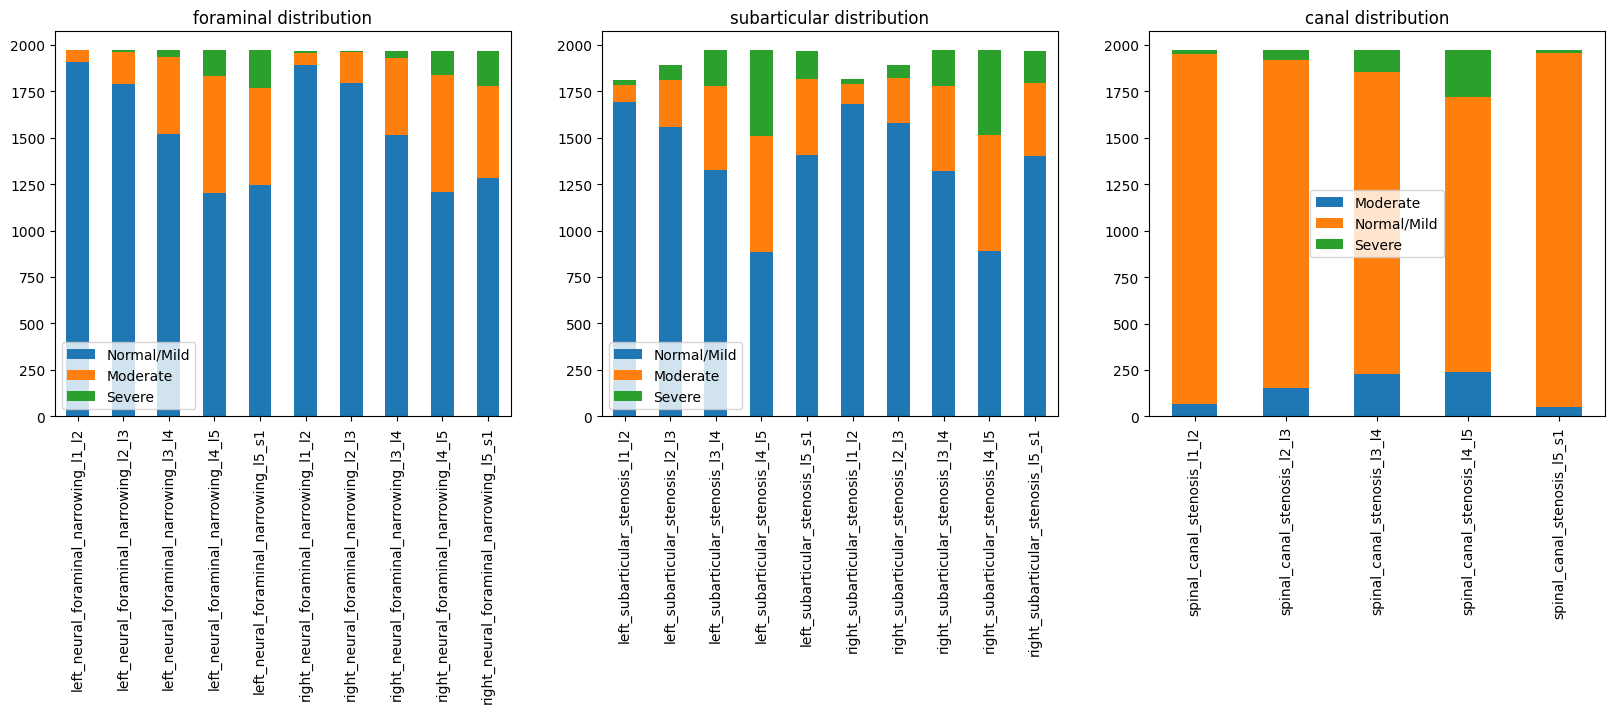

In [11]:
figure, axis = plt.subplots(1,3, figsize=(20,5))
for idx, d in enumerate(['foraminal', 'subarticular', 'canal']):
    diagnosis = list(filter(lambda x: x.find(d) > -1, train.columns))
    dff = train[diagnosis]
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        value_counts = dff.apply(pd.value_counts).fillna(0).T
    value_counts.plot(kind='bar', stacked=True, ax=axis[idx])
    axis[idx].set_title(f'{d} distribution')

In [12]:
# List out all of the Studies we have on patients.
part_1 = os.listdir(f'{fd}/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))

In [13]:
df_meta_f = pd.read_csv(f'{fd}/train_series_descriptions.csv')

In [14]:
p1 = [(x, f"{fd}/train_images/{x}") for x in part_1]
meta_obj = { p[0]: { 'folder_path': p[1], 'SeriesInstanceUIDs': [] } for p in p1 }

In [16]:
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1,
               os.listdir(meta_obj[m]['folder_path'])
              )
    )

In [17]:
# grabs the correspoding series descriptions
for k in tqdm(meta_obj):
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            meta_obj[k]['SeriesDescriptions'].append(
                df_meta_f[(df_meta_f['study_id'] == int(k)) &
                (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

100%|██████████| 1975/1975 [00:03<00:00, 509.99it/s]


In [19]:
meta_obj[list(meta_obj.keys())[1]]

{'folder_path': '/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252',
 'SeriesInstanceUIDs': ['1267494961', '4079690004', '510506195'],
 'SeriesDescriptions': ['Axial T2', 'Sagittal T1', 'Sagittal T2/STIR']}

In [20]:
patient = train.iloc[1]

In [21]:
ptobj = meta_obj[str(patient['study_id'])]

In [22]:
print(ptobj)

{'folder_path': '/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740', 'SeriesInstanceUIDs': ['3201256954', '3486248476', '3666319702'], 'SeriesDescriptions': ['Axial T2', 'Sagittal T1', 'Sagittal T2/STIR']}


In [23]:
# Get data into the format
"""
im_list_dcm = {
    '{SeriesInstanceUID}': {
        'images': [
            {'SOPInstanceUID': ...,
             'dicom': PyDicom object
            },
            ...,
        ],
        'description': # SeriesDescription
    },
    ...
}
"""
im_list_dcm = {}
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm")
    for j in sorted(images, key=lambda x: int(x.split('/')[-1].replace('.dcm', ''))):
        im_list_dcm[i]['images'].append({
            'SOPInstanceUID': j.split('/')[-1].replace('.dcm', ''),
            'dicom': pydicom.dcmread(j) })

In [24]:
# Function to display images
def display_images(images, title, max_images_per_row=4):
    # Calculate the number of rows needed
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Ceiling division

    # Handle the case when num_rows is 0
    if num_rows == 0:
        num_rows = 1  # Set at least one row to display images

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5, 1.5 * num_rows))

    # Flatten axes array for easier looping if there are multiple rows
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable for consistency

    # Plot each image
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image, cmap='gray')  # Assuming grayscale for simplicity, change cmap as needed
        ax.axis('off')  # Hide axes

    # Turn off unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()

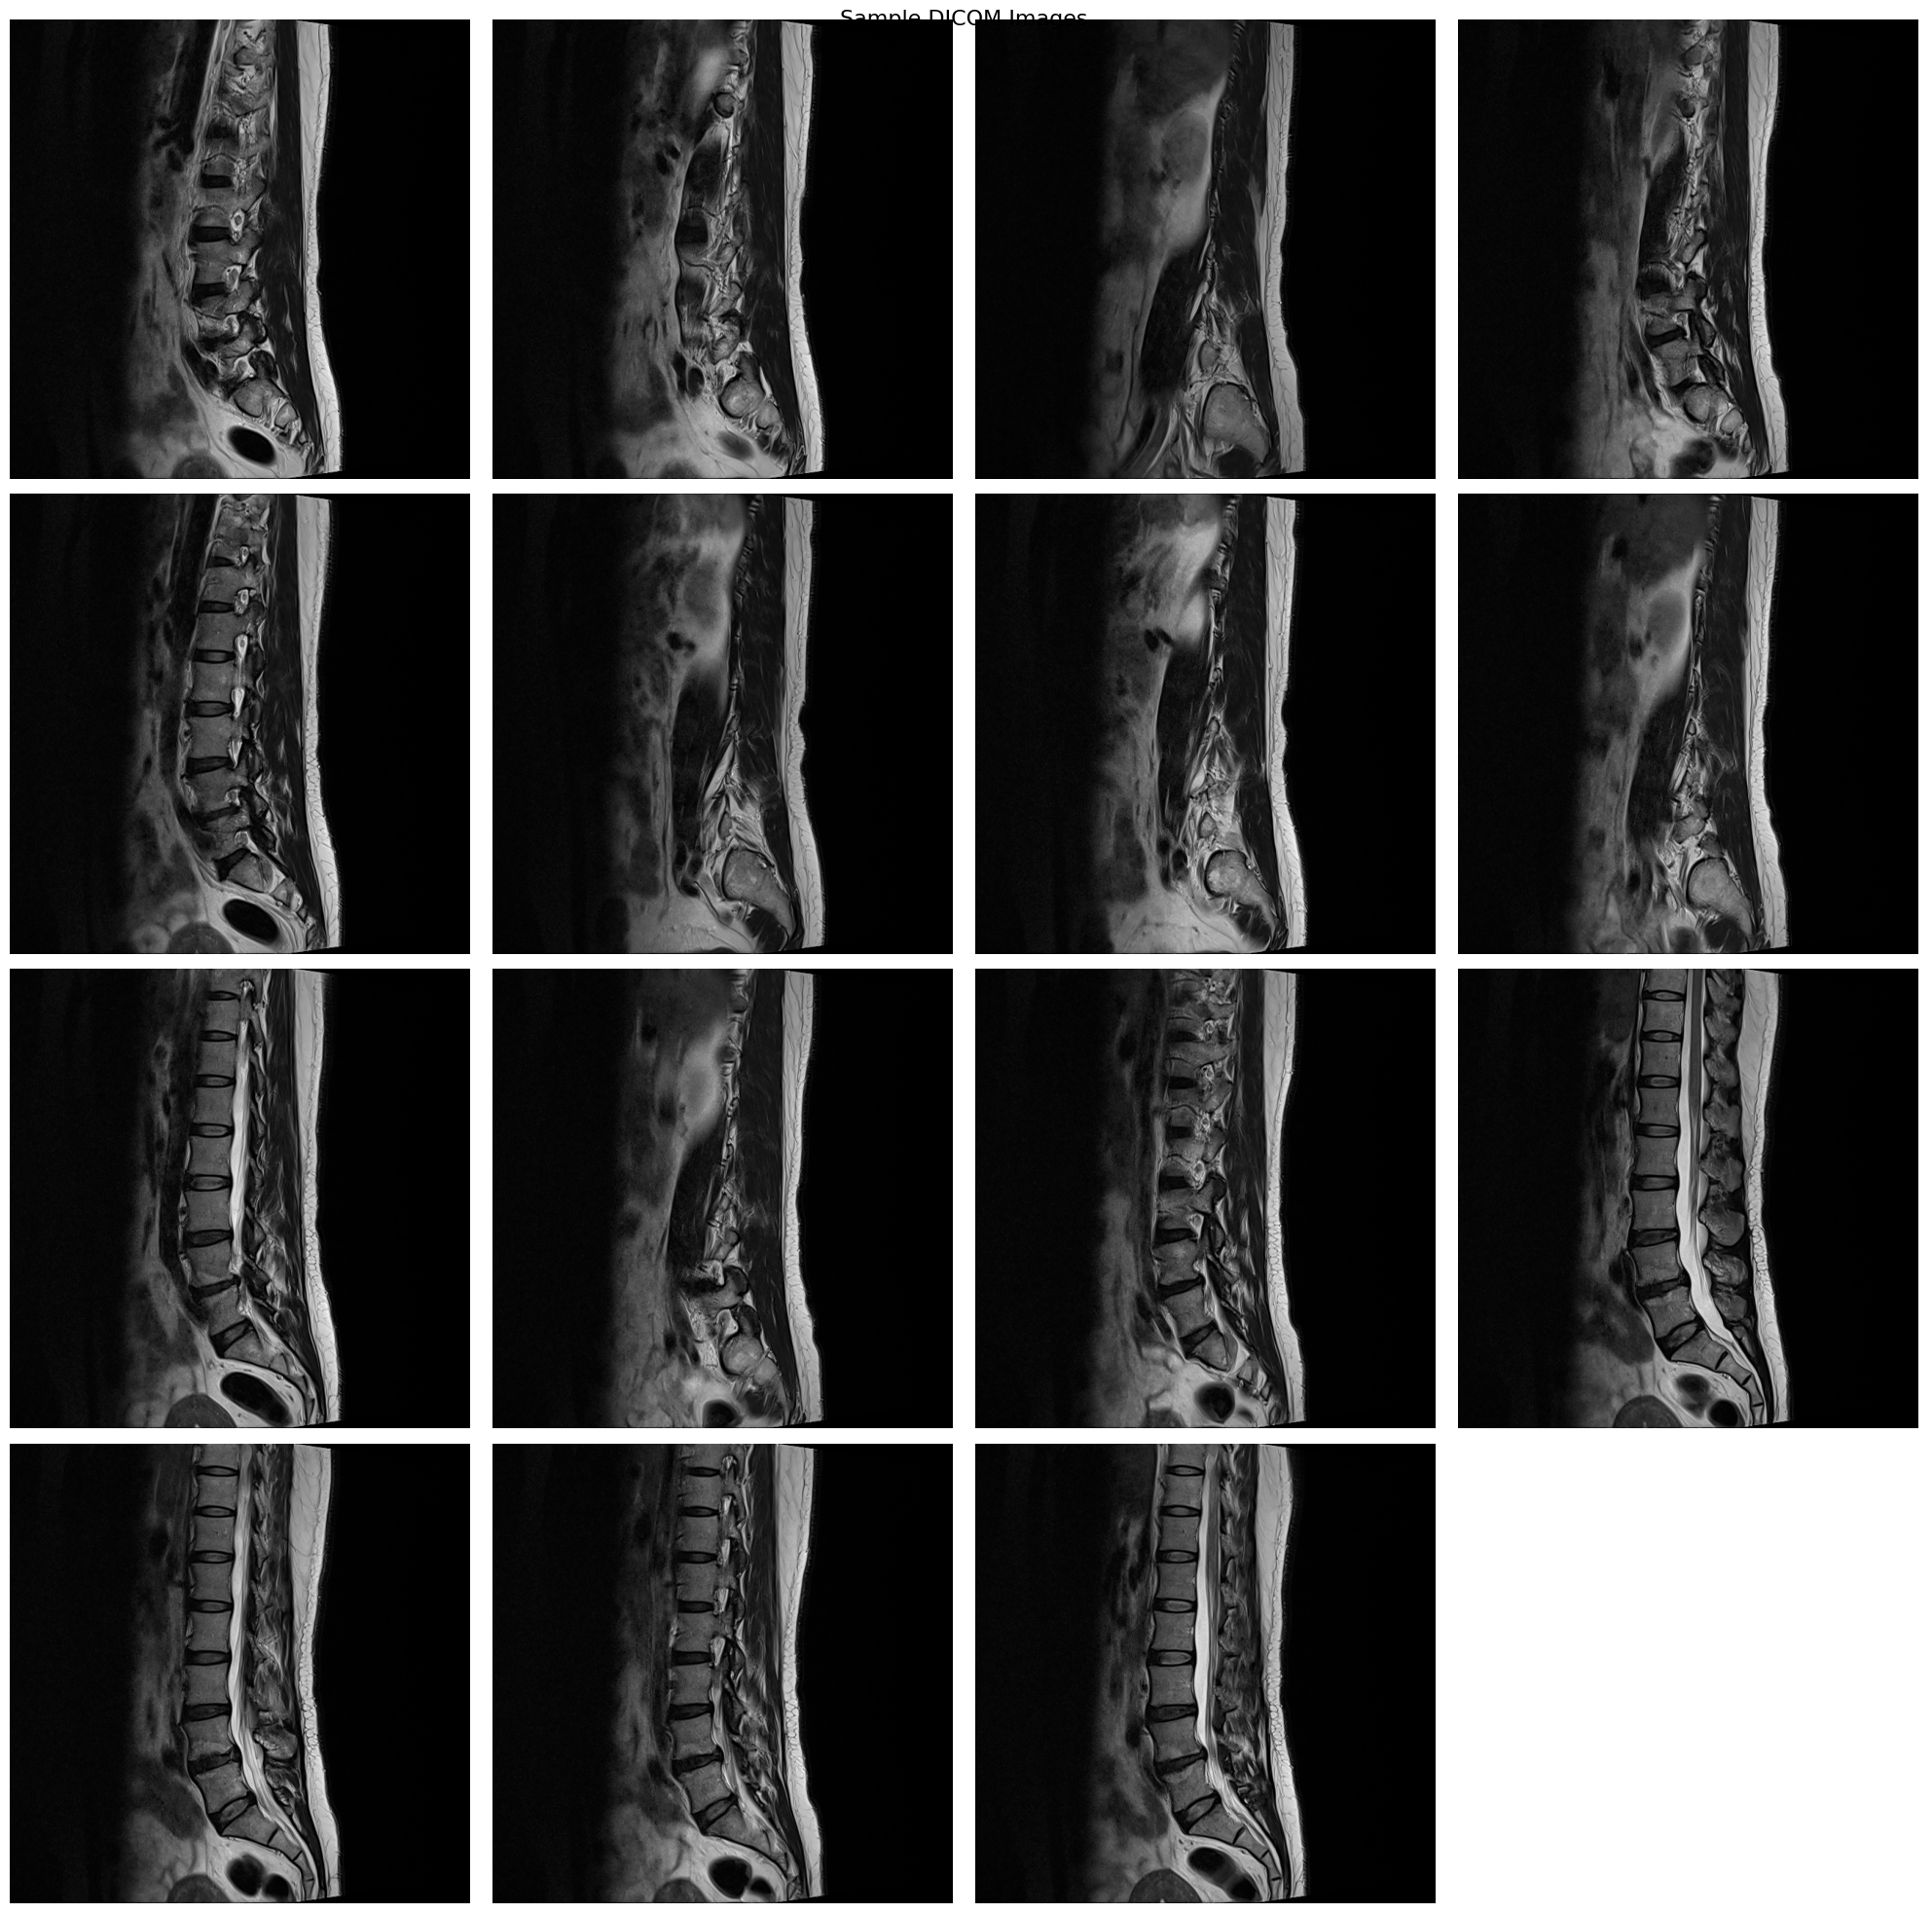

In [25]:
import pydicom
import matplotlib.pyplot as plt
import os

# Function to display images
def display_images(images, title, max_images_per_row=4):
    # Calculate the number of rows needed
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Ceiling division

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5 * max_images_per_row, 5 * num_rows))

    # Flatten axes array for easier looping if there are multiple rows
    axes = axes.flatten()

    # Plot each image
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image, cmap='gray')  # Assuming grayscale for simplicity, change cmap as needed
        ax.axis('off')  # Hide axes

    # Turn off unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

# Function to load DICOM images from a given directory
def load_dicom_images_from_dir(directory):
    dicom_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.dcm'):
                dicom_path = os.path.join(root, file)
                dicom = pydicom.dcmread(dicom_path)
                dicom_images.append(dicom.pixel_array)
    return dicom_images

# Display
directory = f'{fd}/train_images/4003253/702807833/'
images = load_dicom_images_from_dir(directory)
display_images(images, title="Sample DICOM Images")

In [26]:
import pandas as pd

# Load the CSV files
train_df = pd.read_csv(f'{fd}/train.csv')
train_coords_df = pd.read_csv(f'{fd}/train_label_coordinates.csv')

# Display the first few rows
print(train_df.head())

   study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
0   4003253                 Normal/Mild                 Normal/Mild   
1   4646740                 Normal/Mild                 Normal/Mild   
2   7143189                 Normal/Mild                 Normal/Mild   
3   8785691                 Normal/Mild                 Normal/Mild   
4  10728036                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
0                 Normal/Mild                 Normal/Mild   
1                    Moderate                      Severe   
2                 Normal/Mild                 Normal/Mild   
3                 Normal/Mild                 Normal/Mild   
4                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l5_s1 left_neural_foraminal_narrowing_l1_l2  \
0                 Normal/Mild                           Normal/Mild   
1                 Normal/Mild                           Normal/M

In [27]:
print(train_coords_df.head(20))

    study_id   series_id  instance_number                         condition  \
0    4003253   702807833                8             Spinal Canal Stenosis   
1    4003253   702807833                8             Spinal Canal Stenosis   
2    4003253   702807833                8             Spinal Canal Stenosis   
3    4003253   702807833                8             Spinal Canal Stenosis   
4    4003253   702807833                8             Spinal Canal Stenosis   
5    4003253  1054713880                4  Right Neural Foraminal Narrowing   
6    4003253  1054713880                4  Right Neural Foraminal Narrowing   
7    4003253  1054713880                5  Right Neural Foraminal Narrowing   
8    4003253  1054713880                6  Right Neural Foraminal Narrowing   
9    4003253  1054713880                6  Right Neural Foraminal Narrowing   
10   4003253  1054713880               11   Left Neural Foraminal Narrowing   
11   4003253  1054713880               11   Left Neu

In [43]:
import os
import pydicom
import pandas as pd

def get_series_lengths(base_dir, train_df, coords_df):
    lengths = []

    for idx in range(len(train_df)):
        study_id = train_df.iloc[idx]['study_id']

        # Ensure the study_id exists in coords_df
        if study_id in coords_df['study_id'].values:
            series_id = coords_df[coords_df['study_id'] == study_id].iloc[0]['series_id']
            series_dir = os.path.join(base_dir, str(study_id), str(series_id))
            num_images = len([name for name in os.listdir(series_dir) if name.endswith('.dcm')])
            lengths.append(num_images)
        else:
            print(f"Study ID {study_id} not found in coords_df")

    return lengths

# Load CSV files
train_df = pd.read_csv('/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_coords_df = pd.read_csv('/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

# Base directory for images
base_dir = '/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification/train_images/'

# Calculate series lengths
series_lengths = get_series_lengths(base_dir, train_df, train_coords_df)

# Find the shortest and longest series
shortest_length = min(series_lengths)
longest_length = max(series_lengths)

print(f'Shortest number of images in a series: {shortest_length}')
print(f'Longest number of images in a series: {longest_length}')


Study ID 3008676218 not found in coords_df
Shortest number of images in a series: 0
Longest number of images in a series: 176


In [28]:
import os
import pydicom
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [29]:
# Load CSV files
train_df = pd.read_csv(f'/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_coords_df = pd.read_csv('/content/drive/MyDrive/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

In [30]:
# Convert labels to numerical format
condition_mapping = {
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
}

In [34]:
# Transform to preprocess images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize((0.5,), (0.5,))
])

In [44]:
# Load and preprocess images
def load_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    pixel_array = dicom.pixel_array
    # Convert pixel array to float
    pixel_array = pixel_array.astype(np.float32)
    return pixel_array

In [45]:
def preprocess_images(images, max_length=176):
    processed_images = [transform(image) for image in images]
    if len(processed_images) < max_length:
        # Pad with zeros if less than max_length
        padding = [torch.zeros_like(processed_images[0]) for _ in range(max_length - len(processed_images))]
        processed_images.extend(padding)
    elif len(processed_images) > max_length:
        # Truncate if more than max_length
        processed_images = processed_images[:max_length]
    return torch.stack(processed_images)


In [ ]:
# Function to get labels for a patient
def get_labels(patient_row):
    labels = []
    for col in patient_row.index:
        if col != 'study_id':
            labels.append(condition_mapping[patient_row[col]])
    return labels

In [ ]:
# # Create a dictionary to hold images and labels for each study
im_list_dcm = {}

for idx, row in train_df.iterrows():
    study_id = row['study_id']
    patient_labels = get_labels(row)

    # Find all series for this study in the coords DataFrame
    series_ids = train_coords_df[train_coords_df['study_id']
                                 == study_id]['series_id'].unique()

    im_list_dcm[study_id] = {'images': [],
                             'labels': patient_labels, 'series': {}}

    for series_id in series_ids:
        series_dir = os.path.join(base_dir, str(study_id), str(series_id))
        images = load_dicom_images_from_dir(series_dir)

        # Only preprocess and add if there are images
        if images:
            preprocessed_images = preprocess_images(images)
            im_list_dcm[study_id]['series'][series_id] = preprocessed_images

# ------------------------------DEBUGGING-------------------------------------------
# Print a summary
for study_id, data in im_list_dcm.items():
    print(f"Study ID: {study_id}")
    print(f"Labels: {data['labels']}")
    for series_id, images in data['series'].items():
        print(f"  Series ID: {series_id}, Number of images: {len(images)}")
# ------------------------------DEBUGGING-------------------------------------------


In [52]:
class SpineDataset(Dataset):
    def __init__(self, im_list_dcm):
        self.im_list_dcm = im_list_dcm
        self.study_ids = list(im_list_dcm.keys())

    def __len__(self):
        return len(self.study_ids)

    def __getitem__(self, idx):
        study_id = self.study_ids[idx]
        data = self.im_list_dcm[study_id]

        # Combine all series images into one tensor
        series_images = []
        for series_id, images in data['series'].items():
            series_images.append(images)

        if len(series_images) == 0:
            raise RuntimeError(f"No valid images found for study ID {study_id}")

        # Stack all series images along the first dimension
        all_images = torch.cat(series_images, dim=0)
        labels = torch.tensor(data['labels'], dtype=torch.long)
        return all_images, labels

In [ ]:
# Example usage:
dataset = SpineDataset(im_list_dcm)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Print a batch of data to verify
for batch in dataloader:
    images, labels = batch
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break


In [53]:
# Base directory for images
base_dir = f'{fd}/train_images/'

# Create dataset and dataloader
train_dataset = SpineDataset(train_df, train_coords_df, base_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [54]:
# Instantiate the model
model = MultiLevelUnet(in_channels=1, num_classes=15).to(device)  # 15 output classes (3 severity levels for 5 conditions)

In [55]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
# Training loop
def train_model(model, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

In [ ]:
# Train the model
train_model(model, train_loader, num_epochs=10)